<a href="https://colab.research.google.com/github/uceku95/A-Deep-Learning-model-for-classifying-anatomical-structure-in-2D-Fetal-ultrasound-images/blob/main/classifi_fetal_ultrasound_imgs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
import os
import pandas as pd

In [ ]:

# Load the Excel file into a pandas DataFrame
data = pd.read_csv("/content/drive/MyDrive/Classification-20230826T054942Z-001/Classification/image_label.csv")

# Path to the directory containing the images
image_folder = "/content/drive/MyDrive/Classification-20230826T054942Z-001/Classification/images"

# Get the list of image filenames from the image folder (without extensions)
image_filenames = [os.path.splitext(filename)[0] for filename in os.listdir(image_folder) if filename.endswith(".png")]

# Filter the DataFrame to include only rows with image filenames in the image folder
filtered_data = data[data['Image_name'].isin(image_filenames)]

# Save the cleaned data to a new Excel file
filtered_data.to_excel("cleaned_ultrasound_data.xlsx", index=False)
data = pd.read_excel("/content/cleaned_ultrasound_data.xlsx")

In [ ]:

data.head()
data.shape
# Create a mapping of class names to labels
class_names = data['Plane'].unique()
class_to_label = {class_name: label for label, class_name in enumerate(class_names)}
# Define a custom dataset
from PIL import Image
class UltrasoundDataset(Dataset):
    def __init__(self, data, image_folder, transform=None):
        self.data = data
        self.image_folder = image_folder
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_name = self.data.iloc[idx]['Image_name']
        image_path = os.path.join(self.image_folder, image_name + ".png")
        image = Image.open(image_path).convert('RGB')
        label = class_to_label[self.data.iloc[idx]['Plane']]

        if self.transform:
            image = self.transform(image)

        return image, label
# Hyperparameters
batch_size = 16
learning_rate = 0.001
num_epochs = 5
num_classes = len(class_names)
# Load and preprocess data
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
dataset = UltrasoundDataset(data, image_folder, transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
from torch.utils.data import DataLoader, random_split
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
# Initialize the ResNet-18 model
model = models.resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, num_classes)
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)
from sklearn.metrics import accuracy_score

# Training loop
for epoch in range(num_epochs):
    model.train()
    all_train_predictions = []
    all_train_labels = []

    for images, labels in dataloader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        all_train_predictions.extend(predicted.cpu().numpy())
        all_train_labels.extend(labels.cpu().numpy())

    # Calculate training accuracy
    train_accuracy = accuracy_score(all_train_labels, all_train_predictions)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Training Accuracy: {train_accuracy:.4f}")

    # Validation loop (same as before)
    model.eval()
    all_val_predictions = []
    all_val_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            all_val_predictions.extend(predicted.cpu().numpy())
            all_val_labels.extend(labels.cpu().numpy())

    # Calculate validation accuracy
    val_accuracy = accuracy_score(all_val_labels, all_val_predictions)
    print(f"Validation Accuracy: {val_accuracy:.4f}")

# Save the trained model
torch.save(model.state_dict(), "resnet18_ultrasound_model.pth")
model.eval()

# Preprocess function
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    image = Image.open(image_path).convert('RGB')
    image = transform(image)
    image = image.unsqueeze(0)  # Add a batch dimension
    return image

# Path to the folder containing test images
test_images_folder = "/content/drive/MyDrive/Classification-20230826T054942Z-001/Classification/External Test images"  # Replace with the actual path

# Loop through each image in the folder
for image_filename in os.listdir(test_images_folder):
    image_path = os.path.join(test_images_folder, image_filename)
    image = preprocess_image(image_path)

    # Make predictions
    with torch.no_grad():
        outputs = model(image)
        _, predicted_class = torch.max(outputs, 1)

    predicted_class_name = class_names[predicted_class.item()]
    print(f"Image: {image_filename}, Predicted class: {predicted_class_name}")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 175MB/s]


Epoch [1/5], Loss: 0.8779, Training Accuracy: 0.8171
Validation Accuracy: 0.7114
Epoch [2/5], Loss: 0.3456, Training Accuracy: 0.9119
Validation Accuracy: 0.8659
Epoch [3/5], Loss: 0.2192, Training Accuracy: 0.9186
Validation Accuracy: 0.9390
Epoch [4/5], Loss: 0.0926, Training Accuracy: 0.9411
Validation Accuracy: 0.9797
Epoch [5/5], Loss: 0.4796, Training Accuracy: 0.9484
Validation Accuracy: 0.9187
Image: Patient01694_Plane3_1_of_3.png, Predicted class: Fetal brain
Image: Patient01665_Plane3_2_of_3.png, Predicted class: Fetal brain
Image: Patient01616_Plane6_1_of_1.png, Predicted class: Fetal thorax
Image: Patient01655_Plane3_1_of_3.png, Predicted class: Fetal brain
Image: Patient01682_Plane3_6_of_6.png, Predicted class: Fetal brain
Image: Patient01701_Plane3_3_of_3.png, Predicted class: Fetal brain
Image: Patient01715_Plane3_2_of_3.png, Predicted class: Fetal brain
Image: Patient01698_Plane6_2_of_3.png, Predicted class: Fetal thorax
Image: Patient01660_Plane6_2_of_2.png, Predicted 

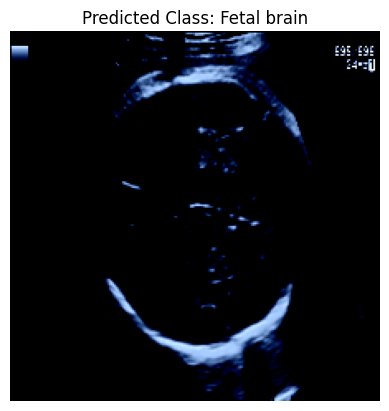

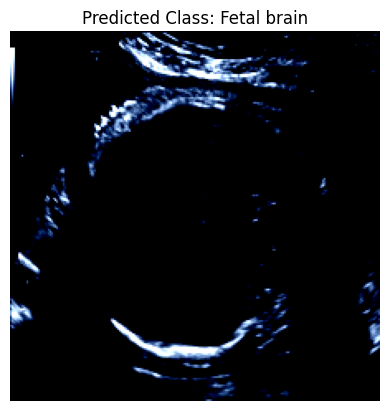

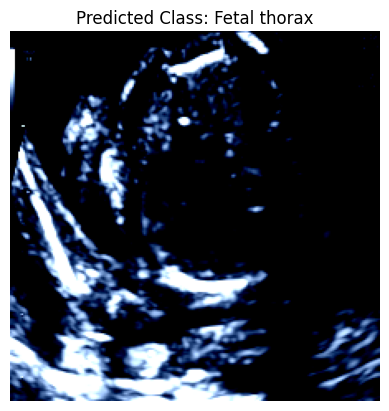

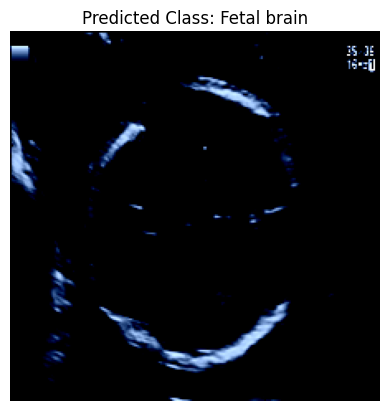

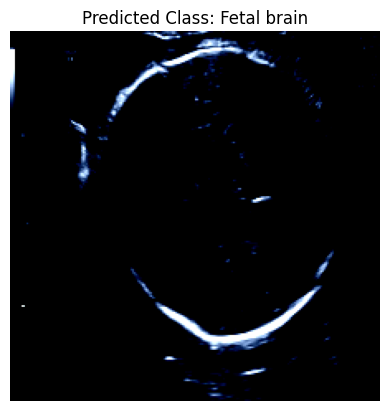

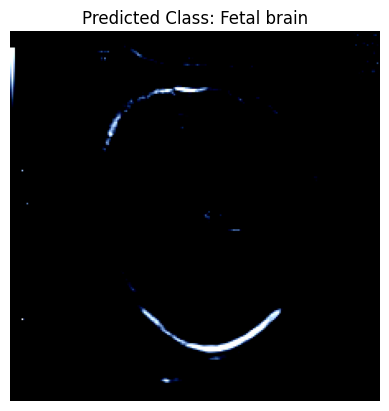

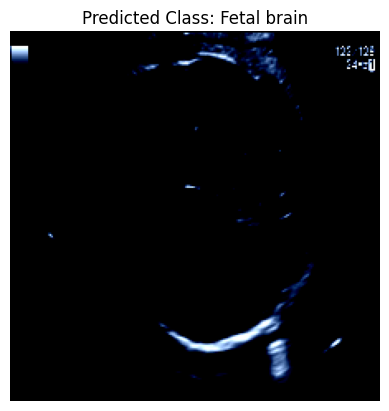

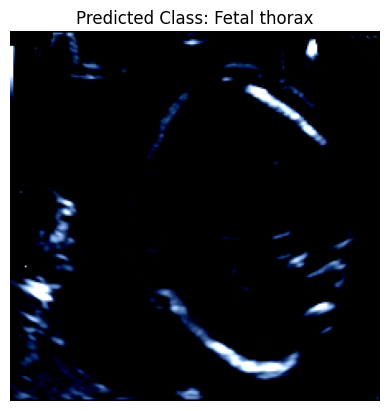

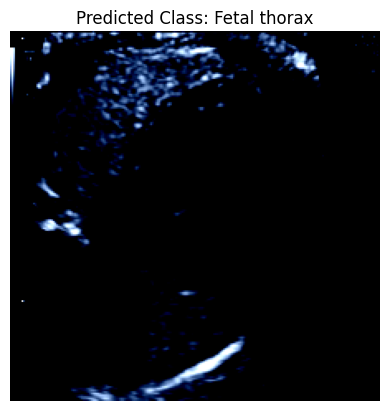

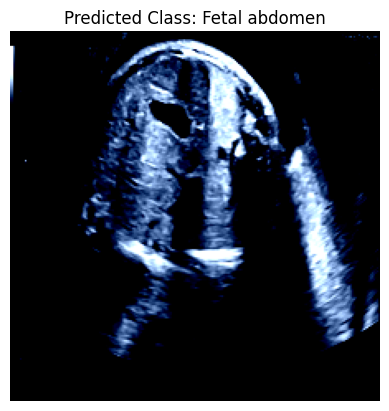

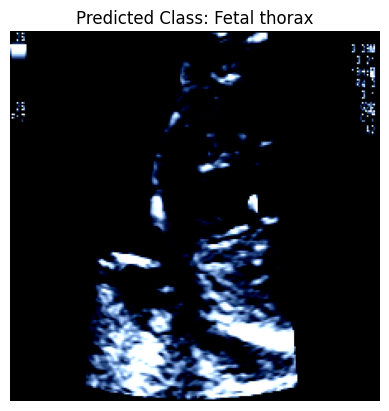

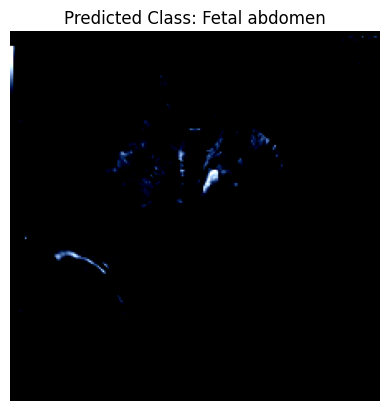

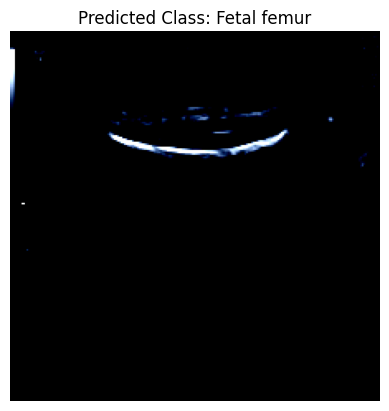

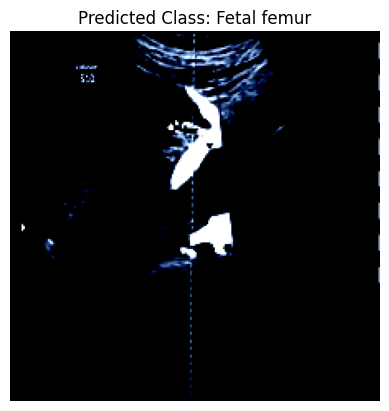

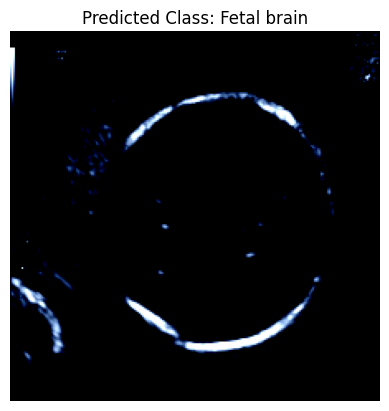

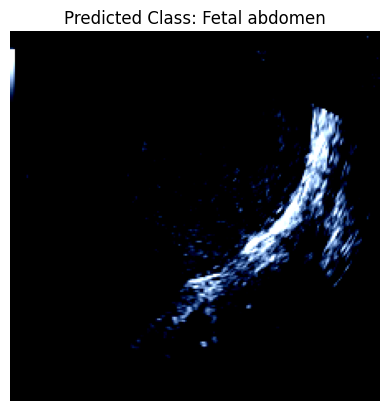

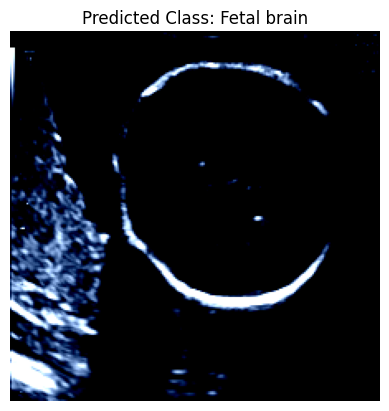

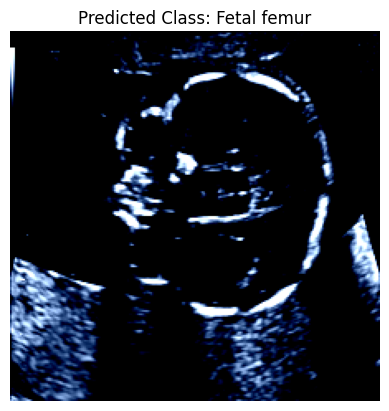

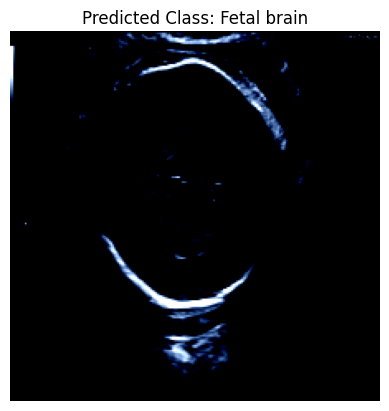

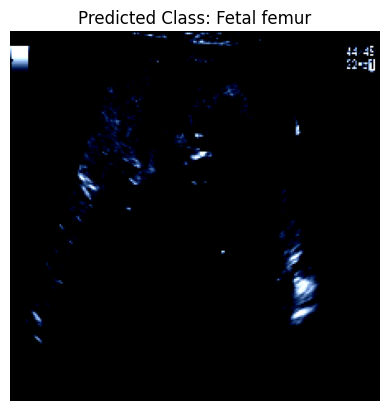

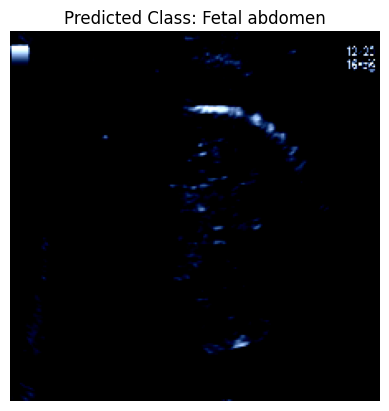

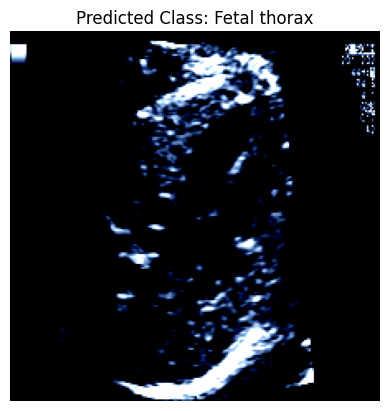

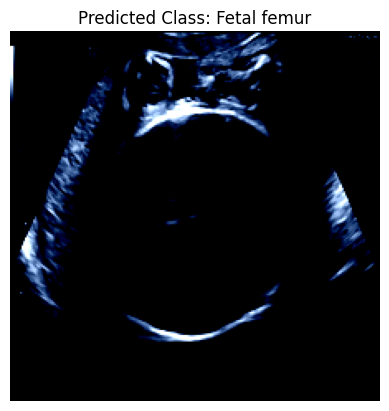

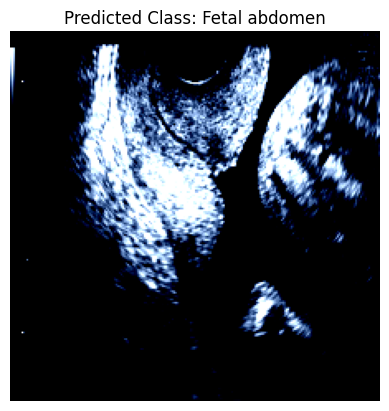

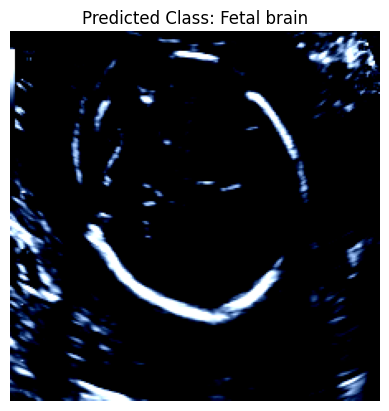

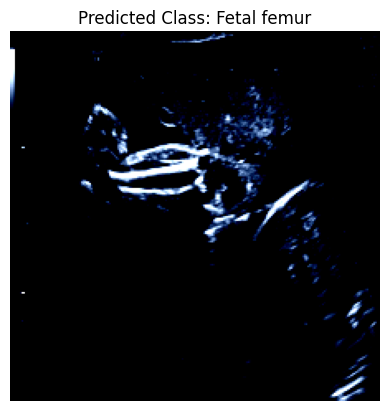

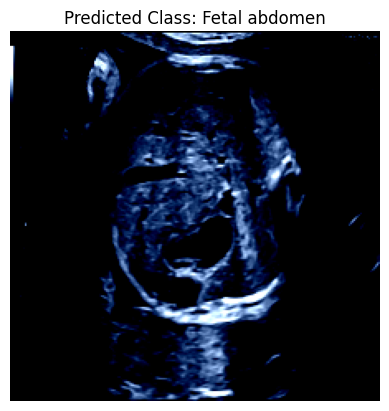

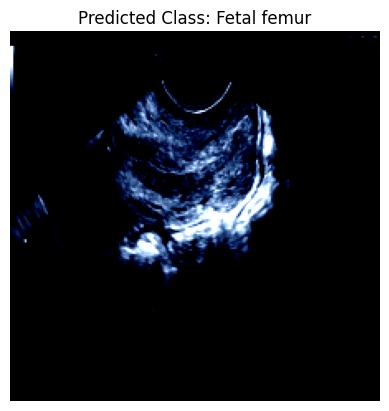

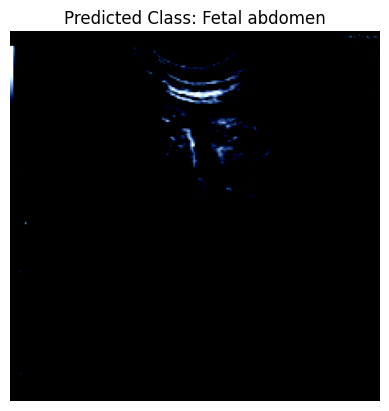

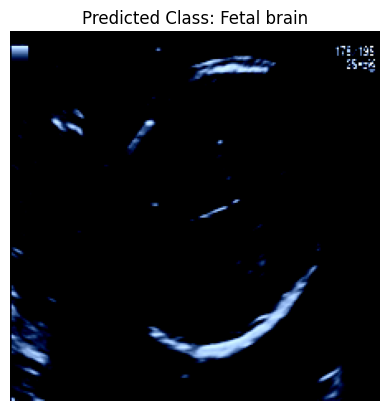

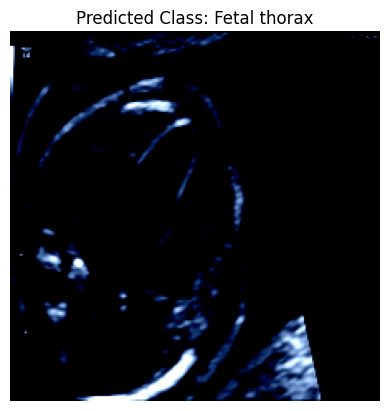

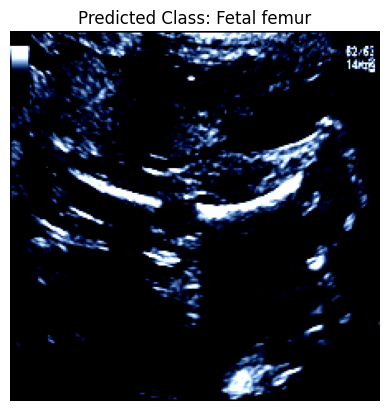

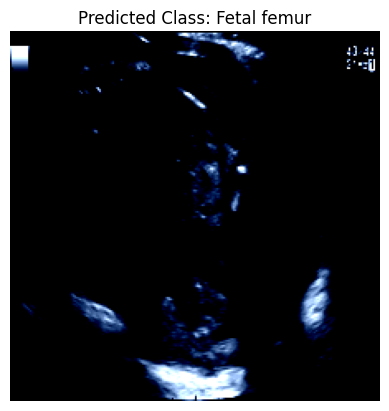

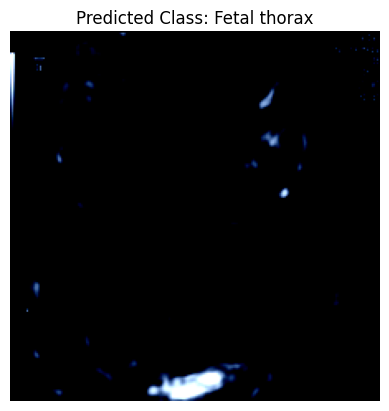

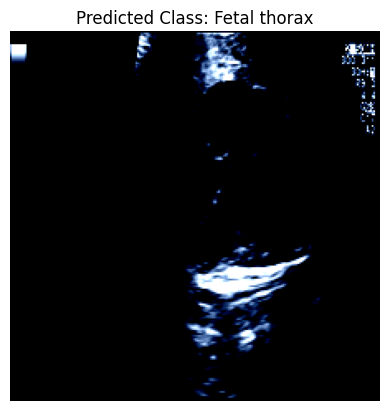

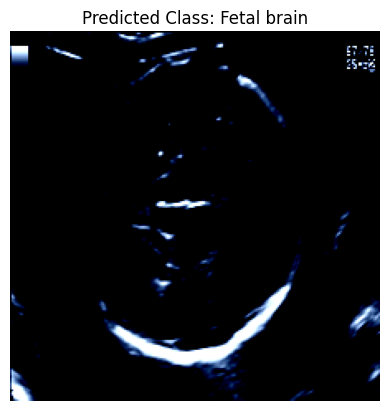

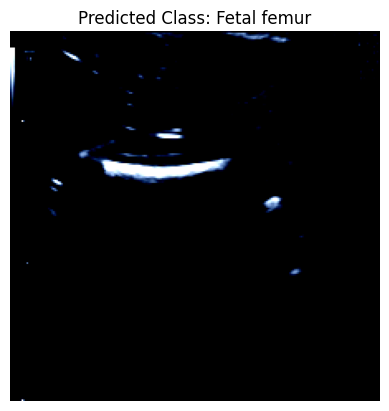

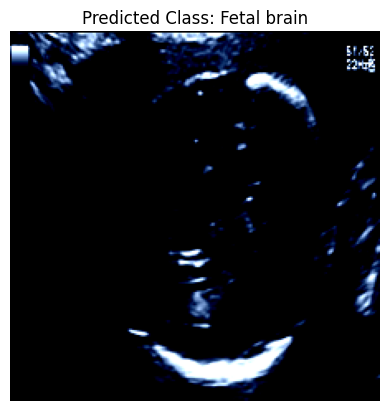

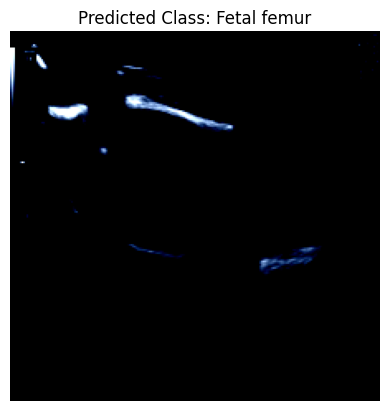

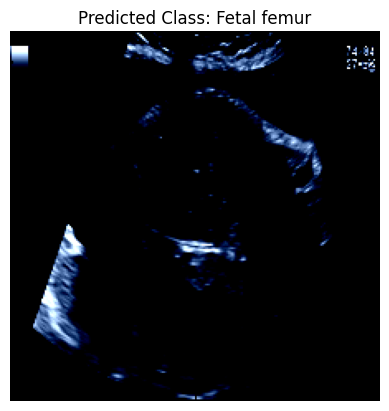

In [ ]:
import matplotlib.pyplot as plt

# Loop through each image in the folder
for image_filename in os.listdir(test_images_folder):
    image_path = os.path.join(test_images_folder, image_filename)
    image = preprocess_image(image_path)

    # Make predictions
    with torch.no_grad():
        outputs = model(image)
        _, predicted_class = torch.max(outputs, 1)

    predicted_class_name = class_names[predicted_class.item()]

    # Display the image and predicted class
    image = image.squeeze(0)  # Remove the batch dimension
    image = image.permute(1, 2, 0)  # Change tensor shape from (C, H, W) to (H, W, C)
    image = image.numpy()  # Convert to NumPy array

    plt.imshow(image)
    plt.title(f"Predicted Class: {predicted_class_name}")
    plt.axis('off')
    plt.show()
